In [1]:
using FFTW, LinearAlgebra
function cubiccos(c1,c2,c3) # Input: Cosine coefficients
    m = length(c1)
    a1 = [reverse(c1[2:end]); c1] # Fourier coefficient
    a2 = [reverse(c2[2:end]); c2] # Fourier coefficient
    a3 = [reverse(c3[2:end]); c3] # Fourier coefficient
    N = 2m # (p-1)m
    ta1 = [zeros(N,1);a1;zeros(N,1)] # 1. Padding zeros
    ta2 = [zeros(N,1);a2;zeros(N,1)]
    ta3 = [zeros(N,1);a3;zeros(N,1)]
    tb1 = ifft(ifftshift(ta1)) # 2. IFFT of ta
    tb2 = ifft(ifftshift(ta2))
    tb3 = ifft(ifftshift(ta3))
    tb³ = tb1 .* tb2 .* tb3    # 3. tb *^ tb *^ tb
    c³ = real(fftshift(fft(tb³))*(6m-1)^2) # 4. FFT of tb_cubic
    return c³[N+m:N+m+3*(m-1)] # return Cosine coefficients
end

function powerconvcos(c,p)
    m = length(c)
    a = [reverse(c[2:end]); c]# Fourier coefficient
    N = (p-1)*m
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = real(fftshift(fft(tbᵖ))*(2.0*p*m-1)^(p-1)) # 4. FFT of tb2
    return cᵖ[N+m:N+m+p*(m-1)]# return Chebyshev coefficients
end

powerconvcos (generic function with 1 method)

In [42]:
function F_equilibrium(c,λ) # Input: cosine Fourier
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    c3 = cubiccos(c,c,c) 
    # @show c
    return λ*c - (1 .- (k/3).^2).^2 .* c - c3[1:N+1]
    # -k.^2*omega^2 .* a + a2[N+1:end]
end

F_equilibrium (generic function with 1 method)

In [43]:
function F_SH!(du, u, p, t)
    du[:] = F_equilibrium(u,p[1])
    # du[1] = 10.0 * (u[2] - u[1])
    # du[2] = u[1] * (28.0 - u[3]) - u[2]
    # du[3] = u[1] * u[2] - (8 / 3) * u[3]
end

F_SH! (generic function with 1 method)

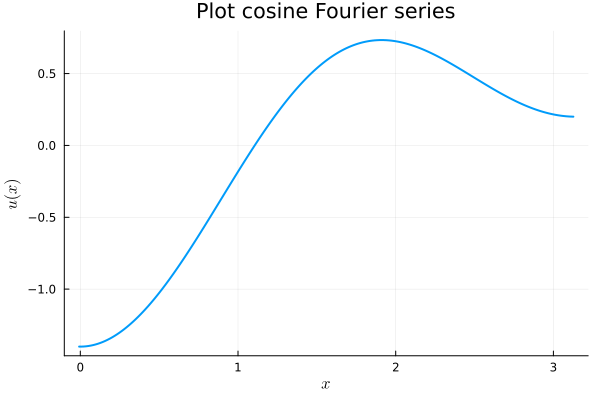

In [44]:
using DifferentialEquations
# Initial data
u0 = zeros(10)
u0[2] = 0.4; u0[3] = -0.3
plot_cos(u0)

In [45]:
# timestep
tspan = [0,.1]
# parameter (λ)
p = [5.0]
# define problem
prob = ODEProblem(F_SH!, u0, tspan, p)
# integrate numerically
sol = solve(prob)
u0 = sol(tspan[2])

10-element Vector{Float64}:
  0.04730675628305278
  0.5340527958265341
 -0.4092259843010914
 -0.027771520848352493
  0.02289174663112511
 -0.01579841782035454
  0.0013691363333117814
  0.0013273371018531833
 -0.0005018242968830006
  6.264873181409596e-5

In [23]:
using Plots
function plot_cos(a)
    cₖ = [reverse(a[2:end]); a]
    N = Int((length(cₖ)+1)/2)# 2N-1
    n_pad = 200
    cₖ_pad = [zeros(n_pad);cₖ;zeros(n_pad)]
    N_pad = N + n_pad
    h_pad = 2.0π/(2N_pad-1)
    xⱼ_pad = h_pad*(0:(2N_pad-2)) .- π
    
    fᴺⱼ_pad = real((2N_pad-1)*ifft(ifftshift(cₖ_pad)))
    plot(xⱼ_pad[N_pad:end], fᴺⱼ_pad[N_pad:end], legend=false, title = "Plot cosine Fourier series",
        line=2,
        xlabel = "\$x\$",
        ylabel = "\$u(x)\$",)
end

plot_cos (generic function with 1 method)

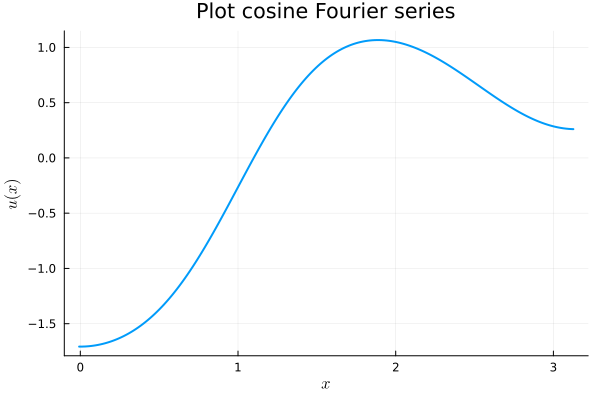

In [46]:
plot_cos(u0)

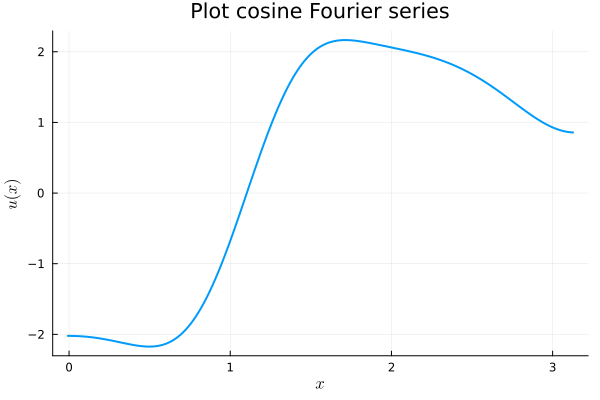

In [47]:
tspan = [.1,.5]
# define problem
prob = ODEProblem(F_SH!, u0, tspan, p)
# integrate numerically
sol = solve(prob)
u0 = sol(tspan[2])
plot_cos(u0)

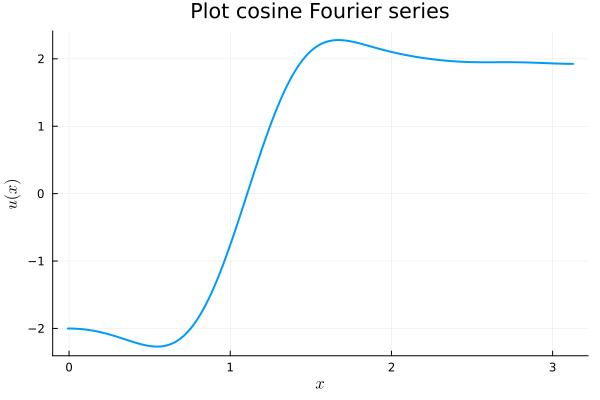

In [48]:
tspan = [.5,1.0]
# define problem
prob = ODEProblem(F_SH!, u0, tspan, p)
# integrate numerically
sol = solve(prob)
u0 = sol(tspan[2])
plot_cos(u0)

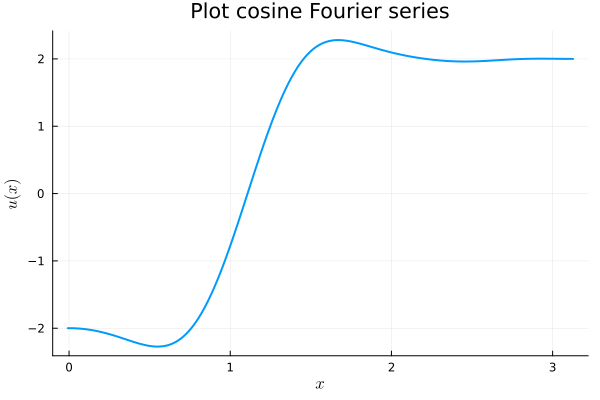

In [49]:
tspan = [1.0,1.5]
# define problem
prob = ODEProblem(F_SH!, u0, tspan, p)
# integrate numerically
sol = solve(prob)
u0 = sol(tspan[2])
plot_cos(u0)

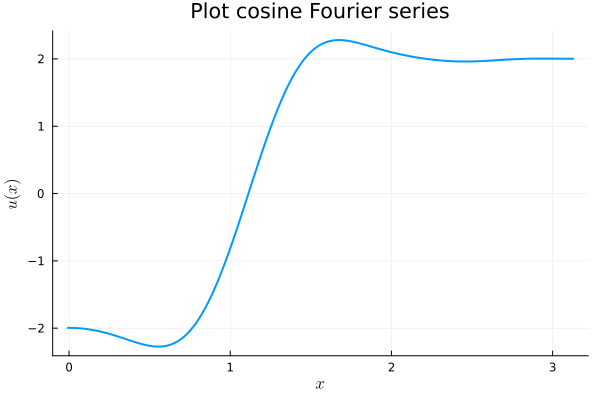

In [50]:
tspan = [1.5,3.0]
# define problem
prob = ODEProblem(F_SH!, u0, tspan, p)
# integrate numerically
sol = solve(prob)
u0 = sol(tspan[2])
plot_cos(u0)

In [51]:
function DF_equilibrium(c,λ)
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    DF_linear = λ .- (1 .- (k/3).^2).^2
    DF_nonlinear = zeros(N+1,N+1)
    c2 = powerconvcos(c,2)
    DF_nonlinear[:,1] = -3 * c2[k .+ 1]
    # @show size(c2)
    for j = 1:N
        # @show  abs.(k .- j) .+ 1
        DF_nonlinear[:,j+1] = -3 * (c2[abs.(k .- j) .+ 1] + c2[abs.(k .+ j) .+ 1])
    end
    return diagm(DF_linear) + DF_nonlinear
end
using LinearAlgebra

function newton_F(c,λ)
    # Newton iteration
    num_itr = 0; p = 1; tol = 5e-10
    Fc = F_equilibrium(c,λ)
    println("Before iteration: $(norm(Fc,p))")
    while num_itr ≤ 100
        DF = DF_equilibrium(c,λ)
        c = c - DF\Fc
        num_itr += 1
        Fc = F_equilibrium(c,λ)
        println("After $(num_itr) iteration: $(norm(Fc,p))")
        if norm(Fc,p) < tol
            break
        end
    end
    return c
end

newton_F (generic function with 1 method)

In [53]:
c0 = newton_F(u0,p[1])

Before iteration: 0.020239320334941746
After 1 iteration: 9.518379091956744
After 2 iteration: 1.611424787822223
After 3 iteration: 0.11785160832713021
After 4 iteration: 1.1168243163325453
After 5 iteration: 0.046391461645506976
After 6 iteration: 0.16615023637575932
After 7 iteration: 0.01351213989439562
After 8 iteration: 0.20303754176425934
After 9 iteration: 0.011208127499024695
After 10 iteration: 0.04349120468029394
After 11 iteration: 0.002702230535904293
After 12 iteration: 0.0012049937852691983
After 13 iteration: 5.0680782126000246e-6
After 14 iteration: 1.4729058528395456e-9
After 15 iteration: 7.521760991835436e-15


10-element Vector{Float64}:
  0.7822148913070291
  1.0536055306755205
 -0.6235854702816606
  0.11858666046588354
  0.17879103208754776
 -0.1599267713943531
  0.041641837163361374
  0.014406355781091538
 -0.016739433468138998
  0.005790722102489961

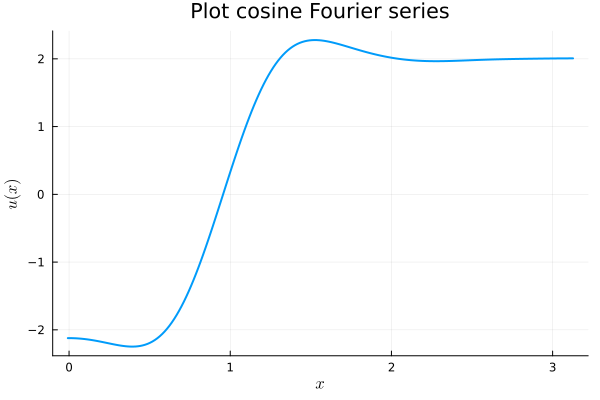

In [54]:
plot_cos(c0)